O objetivo deste notebook é implementar uma árvore de decisão do zero (numpy e pandas), que possuirá a seguinte API:

```Python
df = pd.read_csv("data.csv")

train_df, test_df = train_test_split(df, test_size=0.2)
tree = decision_tree_algorithm(train_df)
accuracy = calculate_accuracy(test_df, tree)
```

# Importar bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
from pprint import pprint

# Biblioteca criada para definir funções auxiliares para o algoritmo principal
import utils 

In [2]:
%matplotlib inline
sns.set_style("darkgrid")

# Carregar e preparar os dados

#### Formato dos dados
- Nesse caso, a última coluna do dataset é o atributo alvo

In [3]:
df = pd.read_csv("data/Iris.csv")
df = df.drop("Id", axis=1)
df = df.rename(columns={"species": "label"})
df.shape

(150, 5)

In [4]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


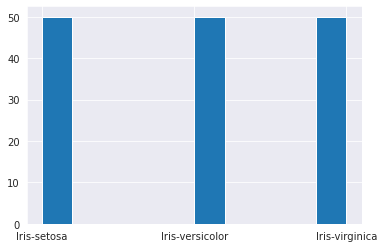

In [5]:
df['label'].hist()

# Divisão de treino e teste

Como as classes estão distruídas igualmente, logo não precisamos realizar a amostragem estratificada

In [6]:
# random.seed(0)
train_df, test_df = utils.train_test_split(df, test_size=20)

In [7]:
data = train_df.values
data[:5]

array([[5.1, 3.5, 1.4, 0.2, 'Iris-setosa'],
       [4.9, 3.0, 1.4, 0.2, 'Iris-setosa'],
       [4.7, 3.2, 1.3, 0.2, 'Iris-setosa'],
       [4.6, 3.1, 1.5, 0.2, 'Iris-setosa'],
       [4.6, 3.4, 1.4, 0.3, 'Iris-setosa']], dtype=object)

### O conjunto ou subconjunto de dados está puro?

In [8]:
# Check if there is only one class on target column
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

### Classificação

Definida pela moda em um problema de classificação

In [9]:
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

### Information Gain

O cálculo de Information Gain permite selecionar a melhor divisão dos dados

In [10]:
def determine_best_split(data, potential_splits, df):
    
    best_information_gain = -9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_left, data_right = utils.split_data(data, split_column=column_index, split_value=value, df=df)
            information_gain = utils.calc_info_gain_numeric(data, data_left, data_right, utils.calc_entropy(data), value)
            
            if information_gain >= best_information_gain:
                best_information_gain = information_gain
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

# Algoritmo da Árvore de Decisão

### Representação da árvore de decisão

In [11]:
sub_tree = {"question": ["yes_answer", 
                         "no_answer"]}

In [12]:
example_tree = {"petal_width <= 0.8": ["Iris-setosa", 
                                      {"petal_width <= 1.65": [{"petal_length <= 4.9": ["Iris-versicolor", 
                                                                                        "Iris-virginica"]}, 
                                                                "Iris-virginica"]}]}

### Algoritmo completo

In [13]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # Data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES, original_data
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = utils.determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # Stop condition
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = utils.get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits, df=original_data)
        data_left, data_right = utils.split_data(data, split_column, split_value, df= original_data)
        
        # check for empty data
        if len(data_left) == 0 or len(data_right) == 0:
            classification = classify_data(data)
            return classification
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_left, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_right, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the question.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [14]:
original_data = train_df
tree = decision_tree_algorithm(train_df, max_depth=3)
pprint(tree)

{'petal_width <= 0.6': ['Iris-setosa',
                        {'petal_width <= 1.7': [{'petal_length <= 5.0': ['Iris-versicolor',
                                                                         'Iris-virginica']},
                                                'Iris-virginica']}]}


# Classificando uma amostra

In [15]:
sub_tree

{'question': ['yes_answer', 'no_answer']}

In [16]:
example = test_df.iloc[0]
example

sepal_length               7.2
sepal_width                  3
petal_length               5.8
petal_width                1.6
label           Iris-virginica
Name: 129, dtype: object

In [17]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":  # feature is continuous
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # leaft node
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [18]:
classify_example(example, tree)

'Iris-virginica'

Train accuracy

In [19]:
accuracy = utils.calculate_accuracy(train_df, tree)
accuracy

0.9769230769230769

Test accuracy

In [20]:
accuracy = utils.calculate_accuracy(test_df, tree)
accuracy

0.95

In [21]:
import sklearn.tree as SKTree
from sklearn.metrics import accuracy_score

clf = SKTree.DecisionTreeClassifier('entropy', max_depth=3)
clf = clf.fit(train_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']], train_df['label'])

print(f"Train accuracy = {accuracy_score(train_df['label'],  clf.predict( train_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']] ) )}")
print(f"Test accuracy = {accuracy_score(test_df['label'],  clf.predict( test_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']] ) )}")


Train accuracy = 0.9769230769230769
Test accuracy = 0.95


In [22]:
pprint(tree, width=50)

{'petal_width <= 0.6': ['Iris-setosa',
                        {'petal_width <= 1.7': [{'petal_length <= 5.0': ['Iris-versicolor',
                                                                         'Iris-virginica']},
                                                'Iris-virginica']}]}


[Text(125.55000000000001, 190.26, 'X[3] <= 0.8\nentropy = 1.584\nsamples = 130\nvalue = [43, 45, 42]'),
 Text(83.7, 135.9, 'entropy = 0.0\nsamples = 43\nvalue = [43, 0, 0]'),
 Text(167.4, 135.9, 'X[3] <= 1.75\nentropy = 0.999\nsamples = 87\nvalue = [0, 45, 42]'),
 Text(83.7, 81.53999999999999, 'X[2] <= 5.05\nentropy = 0.342\nsamples = 47\nvalue = [0, 44, 3]'),
 Text(41.85, 27.180000000000007, 'entropy = 0.156\nsamples = 44\nvalue = [0, 43, 1]'),
 Text(125.55000000000001, 27.180000000000007, 'entropy = 0.918\nsamples = 3\nvalue = [0, 1, 2]'),
 Text(251.10000000000002, 81.53999999999999, 'X[2] <= 4.85\nentropy = 0.169\nsamples = 40\nvalue = [0, 1, 39]'),
 Text(209.25, 27.180000000000007, 'entropy = 0.918\nsamples = 3\nvalue = [0, 1, 2]'),
 Text(292.95, 27.180000000000007, 'entropy = 0.0\nsamples = 37\nvalue = [0, 0, 37]')]

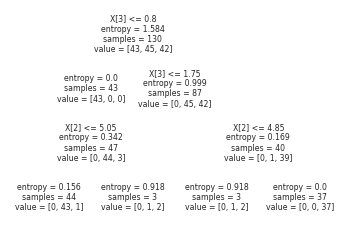

In [23]:
SKTree.plot_tree(clf) 

In [24]:
# Exportar árvore gerada pelo sklearn em PDF

import graphviz 
dot_data = SKTree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

ModuleNotFoundError: No module named 'graphviz'

## Exercício

1) Treinar um classificador de Árvore de Decisão para o dataset Titanic, presente na pasta "data". A árvore gerada terá uma profundidade grande pela quantidade de atributos maior que o dataset da Iris.

2) Fazer um laço de repetição incrementando a profundidade da árvore para (retreinando o classificador) e exibindo a acurácia na base de dados de treino e teste em um gráfico, e então identifcar se ocorre o sobreajuste.

Dica: utilize a implementação do sklearn para facilitar a criação do gráfico.